In [103]:
print(tf.__version__)
print(keras.__version__)
print(np.__version__)

2.5.1
2.5.0
1.19.5


In [97]:
import os
import numpy as np
from PIL import Image

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Layer, Activation, Dense, Flatten, Dropout, Lambda, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, SpatialDropout2D, BatchNormalization
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split


import os
from PIL import Image
from matplotlib.pyplot import imshow
from random import randrange

In [27]:
libpath = 'data/'

In [28]:
dirs = os.listdir(libpath)

In [92]:
dirs

['labels.csv', 'sample_submission.csv', 'test', 'train']

## Importando imagens transformando-as no tamanho adequado

In [95]:
#Carregando as imagens
def carrega_imagens(paths, dirs):
    for i in dirs:
        for r, d, f in os.walk(libpath+i):
            print(libpath+i)
            for file in f:
                if '.jpg' or '.jpeg' in file:
                    paths.append(os.path.join(r, file))
    return paths

In [96]:
paths = []
paths = carrega_imagens(paths, dirs)

data/test
data/train


In [91]:
paths[0]

'data/test\\000621fb3cbb32d8935728e48679680e.jpg'

In [30]:
#Convertendo para Numpy Array
data = []
for path in paths:
    img = Image.open(path)
    img = img.resize((64, 64))
    x = np.array(img)
    data.append(x)

In [33]:
src = np.array(data)

In [34]:
default_height = 64
default_width = 64

## Transformando e separando cojuntos de dados

In [35]:
X_train, X_test, y_train, y_test = train_test_split(src, src, test_size=0.2, shuffle=True, random_state=42)

In [36]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

In [37]:
X_test = X_test / np.max(X_train)
X_train = X_train / np.max(X_train)

In [38]:
X_train.shape

(8177, 64, 64, 3)

In [39]:
X_train.reshape(8177,4096,3)

array([[[0.8392157 , 0.84313726, 0.84705883],
        [0.8235294 , 0.827451  , 0.8352941 ],
        [0.8156863 , 0.81960785, 0.8392157 ],
        ...,
        [0.54509807, 0.63529414, 0.78431374],
        [0.5294118 , 0.61960787, 0.78039217],
        [0.49803922, 0.5882353 , 0.74509805]],

       [[0.80784315, 0.81960785, 0.76862746],
        [0.8117647 , 0.81960785, 0.7764706 ],
        [0.8117647 , 0.81960785, 0.7882353 ],
        ...,
        [0.14509805, 0.18431373, 0.10588235],
        [0.1764706 , 0.21960784, 0.18431373],
        [0.15294118, 0.2       , 0.15686275]],

       [[0.6745098 , 0.6509804 , 0.6509804 ],
        [0.68235296, 0.65882355, 0.65882355],
        [0.7019608 , 0.65882355, 0.6666667 ],
        ...,
        [0.5254902 , 0.53333336, 0.59607846],
        [0.54509807, 0.5411765 , 0.6       ],
        [0.54901963, 0.5529412 , 0.59607846]],

       ...,

       [[0.4862745 , 0.4862745 , 0.4862745 ],
        [0.5058824 , 0.5058824 , 0.5058824 ],
        [0.5058824 , 0

In [40]:
class VQVAELayer(Layer):
    def __init__(self, embedding_dim, num_embeddings, commitment_cost,
                 initializer='uniform', epsilon=1e-10, **kwargs):
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.initializer = initializer
        super(VQVAELayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Add embedding weights.
        self.w = self.add_weight(name='embedding',
                                  shape=(self.embedding_dim, self.num_embeddings),
                                  initializer=self.initializer,
                                  trainable=True)

        # Finalize building.
        super(VQVAELayer, self).build(input_shape)

    def call(self, x):
        # Flatten input except for last dimension.
        flat_inputs = K.reshape(x, (-1, self.embedding_dim))

        # Calculate distances of input to embedding vectors.
        distances = (K.sum(flat_inputs**2, axis=1, keepdims=True)
                     - 2 * K.dot(flat_inputs, self.w)
                     + K.sum(self.w ** 2, axis=0, keepdims=True))

        # Retrieve encoding indices.
        encoding_indices = K.argmax(-distances, axis=1)
        encodings = K.one_hot(encoding_indices, self.num_embeddings)
        encoding_indices = K.reshape(encoding_indices, K.shape(x)[:-1])
        quantized = self.quantize(encoding_indices)

        # Metrics.
        #avg_probs = K.mean(encodings, axis=0)
        #perplexity = K.exp(- K.sum(avg_probs * K.log(avg_probs + epsilon)))
        
        return quantized

    @property
    def embeddings(self):
        return self.w

    def quantize(self, encoding_indices):
        w = K.transpose(self.embeddings.read_value())
        return tf.nn.embedding_lookup(w, encoding_indices, validate_indices=False)

In [49]:
def vq_vae_loss_wrapper(data_variance, commitment_cost, quantized, x_inputs):
    def vq_vae_loss(x, x_hat):
        recon_loss = losses.mse(x, x_hat) / data_variance
        
        e_latent_loss = K.mean((K.stop_gradient(quantized) - x_inputs) ** 2)
        q_latent_loss = K.mean((quantized - K.stop_gradient(x_inputs)) ** 2)
        loss = q_latent_loss + commitment_cost * e_latent_loss
        
        return recon_loss + loss
    return vq_vae_loss

In [50]:
#Número de épocas maximo, afinal uitilizaremos callbacks
epochs = 1000
batch_size = 64
validation_split = 0.1


embedding_dim = 32 
num_embeddings = 128 
commitment_cost = 0.25 

#Early Stopping 
esc = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [58]:
# Encoder
input_img = Input(shape=(default_height, default_width, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
# VQVAELayer.
enc = Conv2D(embedding_dim, kernel_size=(1, 1), strides=(1, 1), name="pre_vqvae")(x)
enc_inputs = enc

data_variance = np.var(X_train)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv2DTranspose(64, (3, 3), activation='relu')(x)
x = UpSampling2D()(x)
x = Conv2DTranspose(32, (3, 3), activation='relu')(x)
x = UpSampling2D()(x)
x = Conv2DTranspose(32, (3, 3), activation='relu')(x)
x = Conv2DTranspose(3, (3, 3))(x)

# Autoencoder.

vqvae = Model(input_img, x)
vqvae.compile(loss=loss,experimental_run_tf_function=False, optimizer='adam')
#vqvae.run_eagerly = True
#vqvae.summary()
# this model maps an input to its encoded representation. Saving it as it's own model

encoder = Model(input_img, enc)
#encoder.summary()

### Plotando Modelos

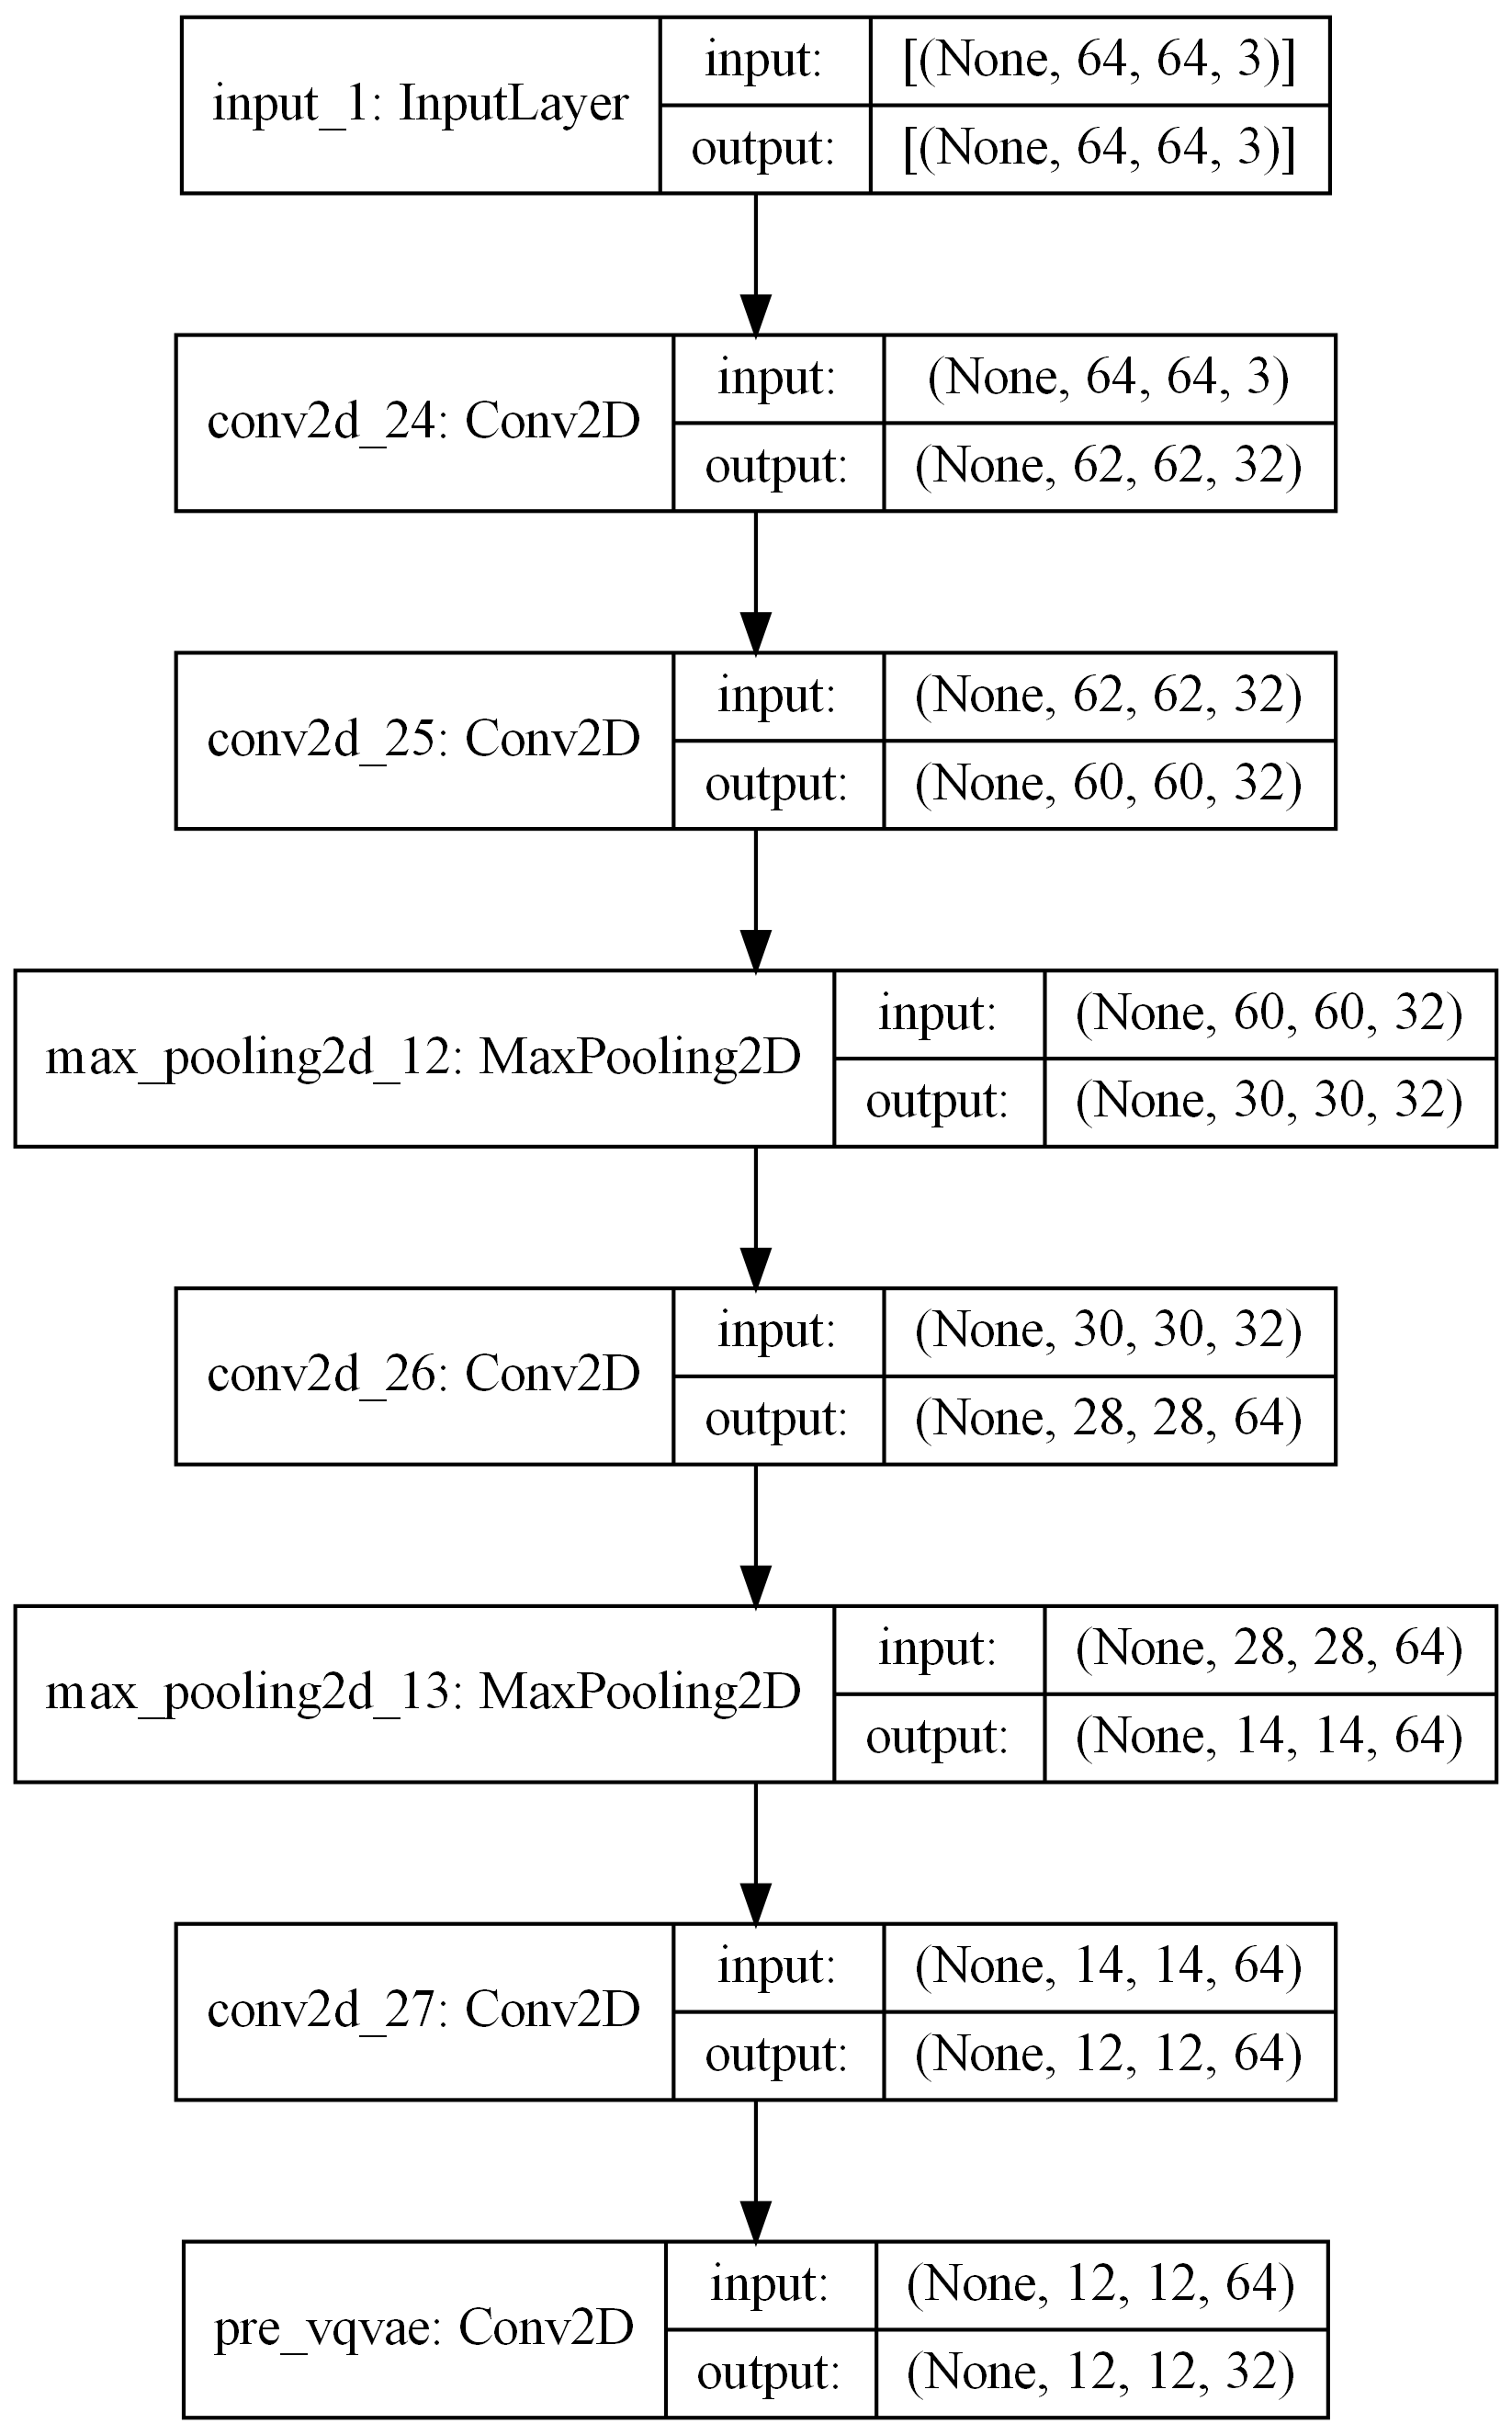

In [98]:
plot_model(encoder, show_shapes=True, dpi=300)

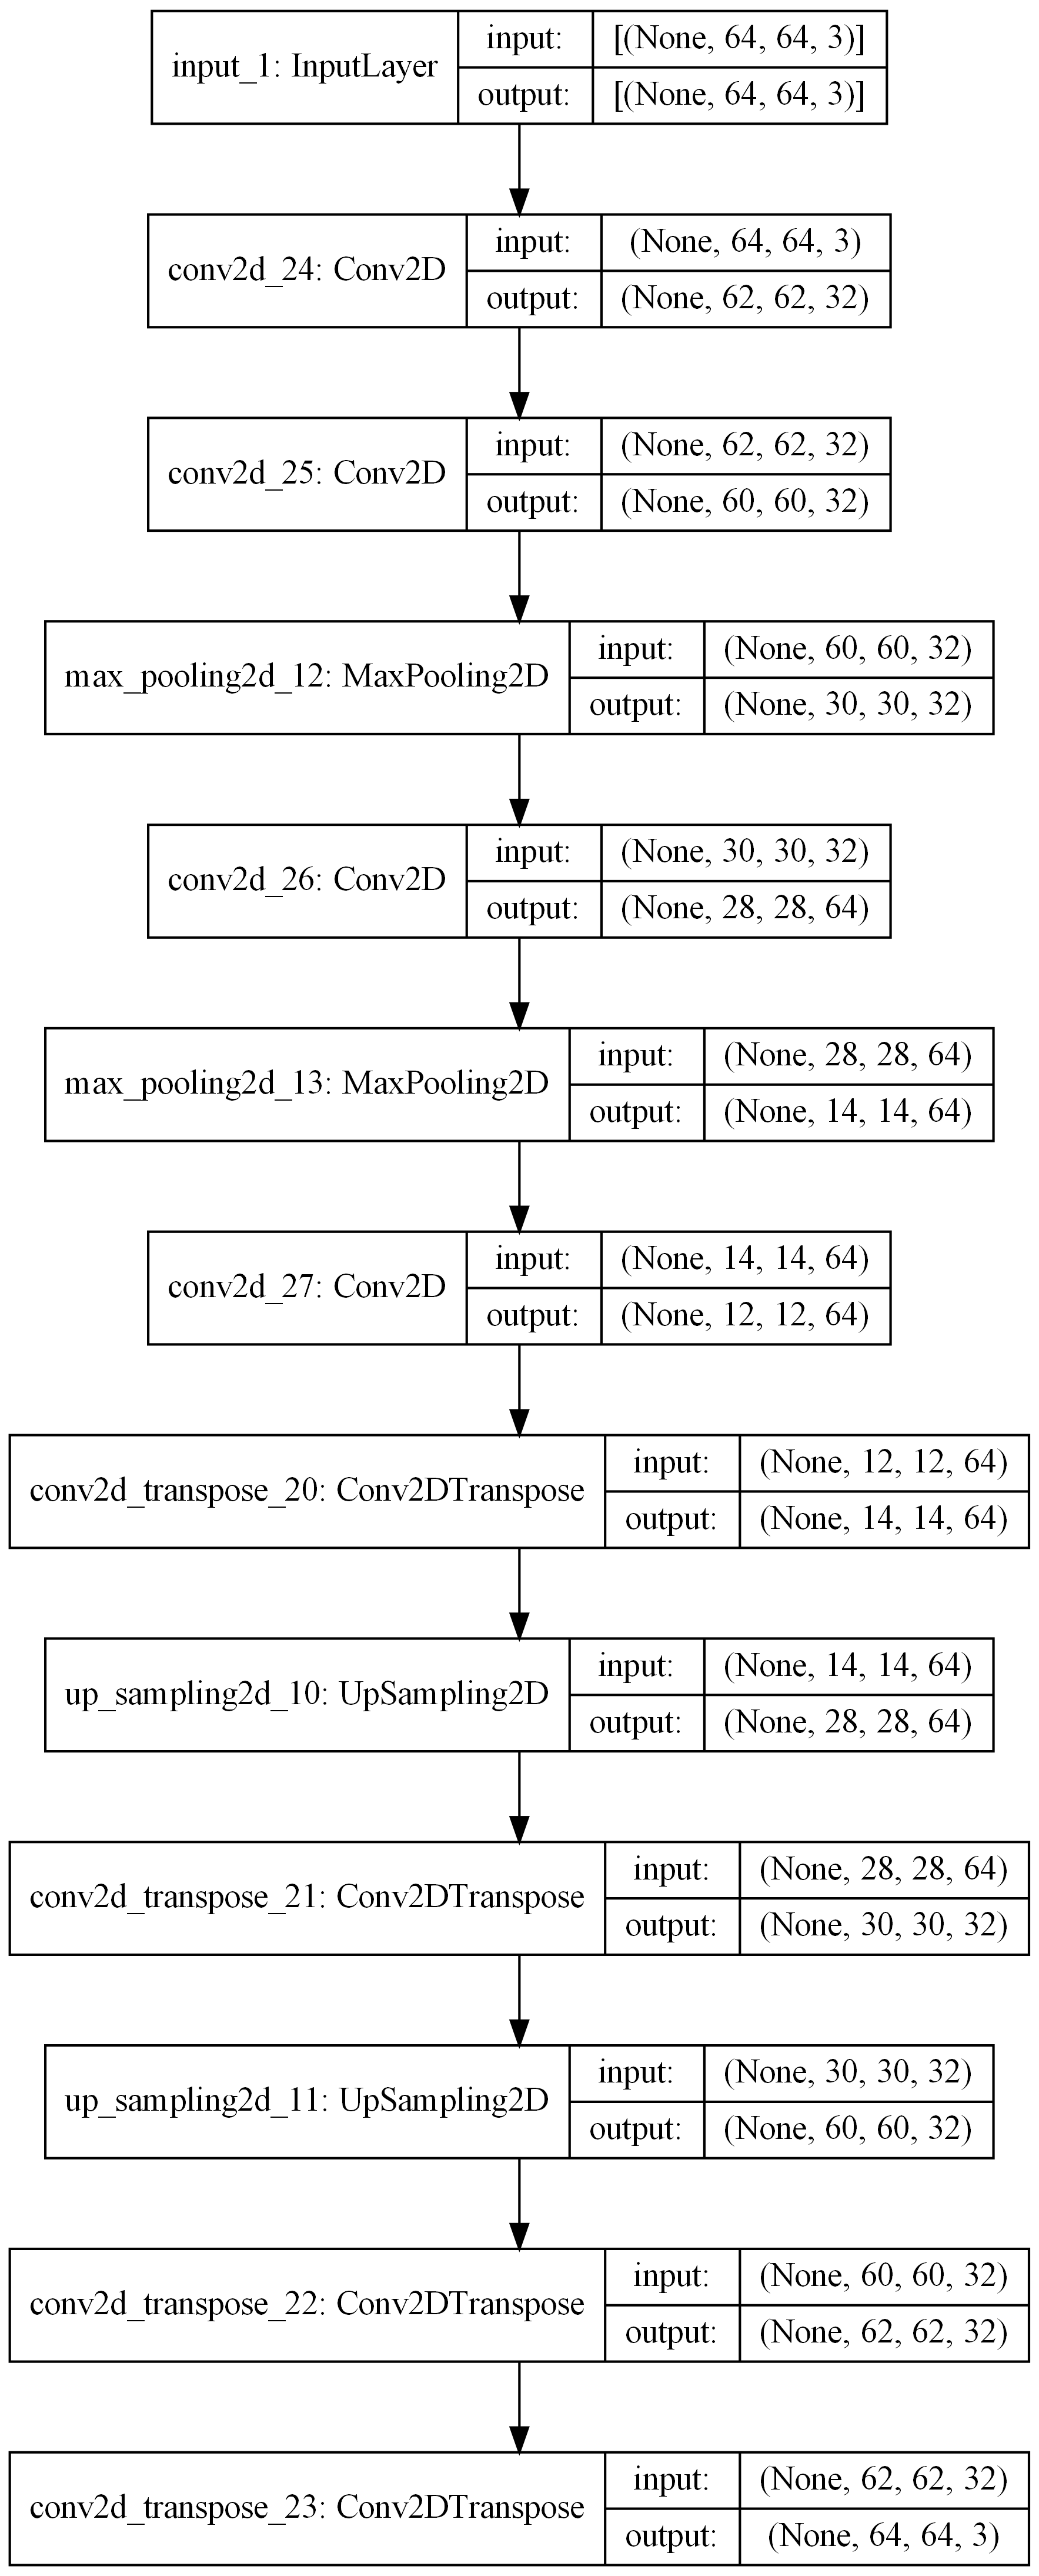

In [100]:
plot_model(vqvae, show_shapes=True, dpi=300)

In [59]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

## Treino do Modelo

In [60]:
history = vqvae.fit(X_train, X_train,
                    batch_size=batch_size, epochs=30,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 7359 samples, validate on 818 samples
Epoch 1/30
7359/7359 [==============================] - ETA: 0s - loss: 0.7116

c:\Users\victo\anaconda3\envs\dev\lib\site-packages\tensorflow\python\keras\engine\training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


7359/7359 [==============================] - 36s 5ms/sample - loss: 0.7116 - val_loss: 0.2527
Epoch 2/30
7359/7359 [==============================] - 36s 5ms/sample - loss: 0.2021 - val_loss: 0.1727
Epoch 3/30
7359/7359 [==============================] - 36s 5ms/sample - loss: 0.1530 - val_loss: 0.1417
Epoch 4/30
7359/7359 [==============================] - 36s 5ms/sample - loss: 0.1292 - val_loss: 0.1164
Epoch 5/30
7359/7359 [==============================] - 36s 5ms/sample - loss: 0.1136 - val_loss: 0.1133
Epoch 6/30
7359/7359 [==============================] - 37s 5ms/sample - loss: 0.1069 - val_loss: 0.1005
Epoch 7/30
7359/7359 [==============================] - 37s 5ms/sample - loss: 0.0994 - val_loss: 0.0962
Epoch 8/30
7359/7359 [==============================] - 37s 5ms/sample - loss: 0.0955 - val_loss: 0.0939
Epoch 9/30
7359/7359 [==============================] - 36s 5ms/sample - loss: 0.0910 - val_loss: 0.0970
Epoch 10/30
7359/7359 [==============================] - 34s 5ms/s

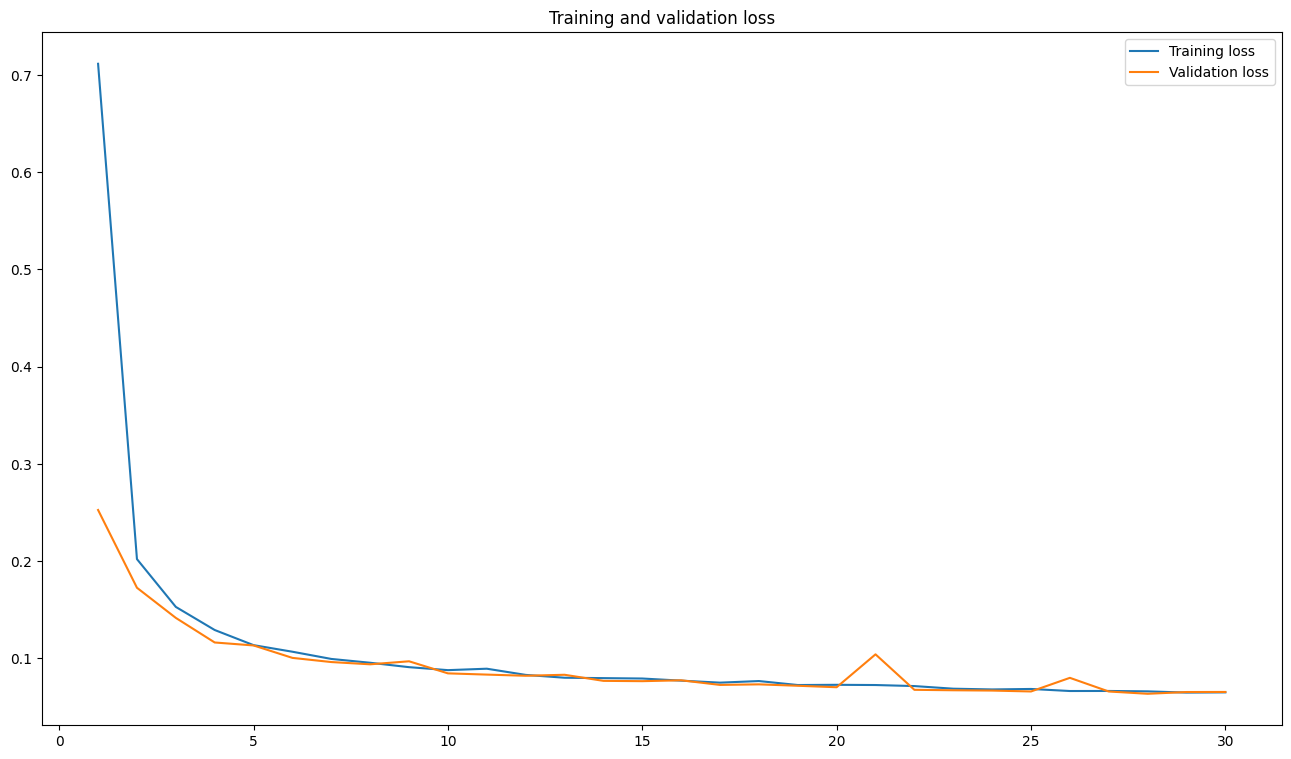

In [61]:
loss = history.history['loss'] # Training loss.
val_loss = history.history['val_loss'] # Validation loss.
num_epochs = range(1, 1 + len(history.history['loss'])) # Number of training epochs.

plt.figure(figsize=(16,9))
plt.plot(num_epochs, loss, label='Training loss') # Plot training loss.
plt.plot(num_epochs, val_loss, label='Validation loss') # Plot validation loss.

plt.title('Training and validation loss')
plt.legend(loc='best')
plt.show()

## Realizando predições com o conjunto de Teste!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


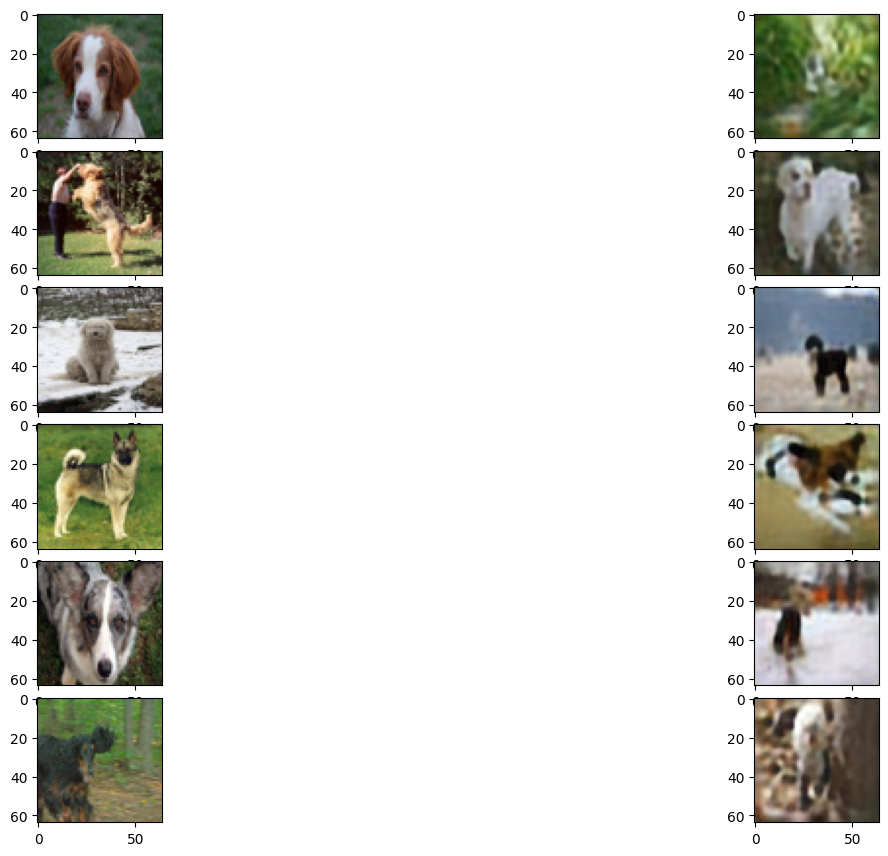

In [82]:
from matplotlib.pyplot import figure
number_of_doggos = 6
f, axarr = plt.subplots(number_of_doggos,2, gridspec_kw = {'wspace':0, 'hspace':0.1})
f.set_size_inches(18.5, 10.5)

for i in range(number_of_doggos):
    index = randrange(len(X_test))
    sample = X_test[index]
    sample = sample.reshape(1,default_height,default_width,3)
    image = vqvae.predict(sample).reshape(default_height,default_width,3)*255
    image = image.astype(int)
    axarr[i,0].imshow(X_train[index])
    axarr[i,1].imshow(image)
    
